**Link Google Driver del Proyecto:** https://drive.google.com/drive/folders/1MVkmphXLYA8M1CF5vrnh6te346lSUwnQ?usp=sharing

# Proyecto: Aplicaciones móviles - Segmentación de usuarios y usuarias en función del comportamiento¶

## Objetivo del Proyecto

Determinar grupos de usuarios y usuarias que difieren en términos de métricas del producto utilizando datos de eventos en una aplicación móvil, y formular y probar hipótesis estadísticas basadas en estos datos.

**Objetivo:**

Segmentar a los usuarios y las usuarias en función de los eventos que completan en la aplicación móvil y formular hipótesis estadísticas sobre las diferencias en métricas clave.

**Beneficiario:**

Equipo de Producto y Marketing.

**Decisiones:**

Estrategias de mejora de retención, optimización de la experiencia del usuario, y estrategias de adquisición de usuarios.

**Fuentes de Datos:**

In [1]:
#Librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind, mannwhitneyu

# Cargar datos
mobile_data = pd.read_csv('/datasets/mobile_dataset_us.csv')
mobile_sources = pd.read_csv('/datasets/mobile_sources_us.csv')

In [2]:
# Mostrar las primeras filas del DataFrame
mobile_data.info()
mobile_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [3]:
# Mostrar las primeras filas del DataFrame
mobile_sources.info()
mobile_sources.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,bing
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,bing
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


### Preprocesamiento de Datos

### Segmentación de Usuarios

**Estudio de Valores Ausentes**

In [4]:
# Identificar valores ausentes en cada columna
print("Valores ausentes en mobile_data:")
print(mobile_data.isnull().sum())

print("\nValores ausentes en mobile_sources:")
print(mobile_sources.isnull().sum())

Valores ausentes en mobile_data:
event.time    0
event.name    0
user.id       0
dtype: int64

Valores ausentes en mobile_sources:
userId    0
source    0
dtype: int64


**Estudio de Tipos de Datos**

In [5]:
# Convertir 'event.time' a datetime
mobile_data['event.time'] = pd.to_datetime(mobile_data['event.time'])

# Mostrar los tipos de datos para revisar
print(mobile_data.dtypes)

event.time    datetime64[ns]
event.name            object
user.id               object
dtype: object


In [6]:
# Describir todas las columnas para las que se pueden calcular estadísticas descriptivas
print(mobile_data.describe(datetime_is_numeric=True))

# Estadísticas de fechas si 'event_time' es una columna de fecha
if 'event_time' in mobile_data.columns:
    print("Event time range: ", mobile_data['event_time'].min(), "to", mobile_data['event_time'].max())

                          event.time
count                          74197
mean   2019-10-21 15:32:09.039316992
min       2019-10-07 00:00:00.431357
25%    2019-10-14 22:04:27.791869952
50%    2019-10-22 00:26:56.715014912
75%    2019-10-28 12:35:53.023877120
max       2019-11-03 23:58:12.532487


### Análisis Exploratorio de Datos (EDA)

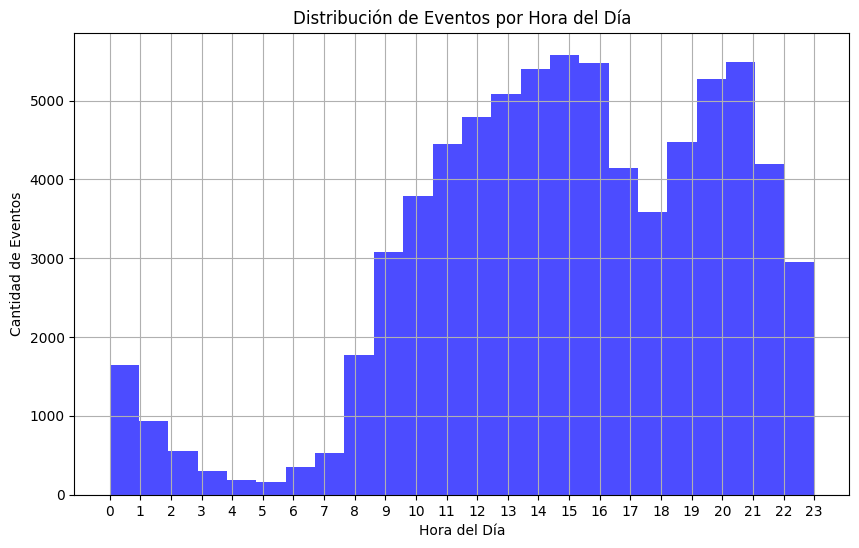

In [7]:
# Extraer la hora del día de 'event_time'
mobile_data['hour_of_day'] = mobile_data['event.time'].dt.hour

#histograma de las horas del día
plt.figure(figsize=(10, 6))
plt.hist(mobile_data['hour_of_day'], bins=24, color='blue', alpha=0.7)
plt.title('Distribución de Eventos por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Eventos')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

**Baja Actividad Nocturna:** Muy pocos eventos ocurren entre la medianoche y las 6 AM, lo que sugiere que la mayoría de los usuarios están inactivos durante estas horas.

**Incremento en la Mañana:** Hay un aumento notable en la actividad a partir de las 6 AM, con un pico moderado alrededor de las 8-9 AM, posiblemente indicando el uso de la aplicación durante las horas de inicio del día o el traslado matutino.

**Pico Principal en la Noche:** La actividad alcanza su máximo entre las 21 y las 22 horas, lo que puede reflejar un uso intensivo durante el tiempo de ocio nocturno.


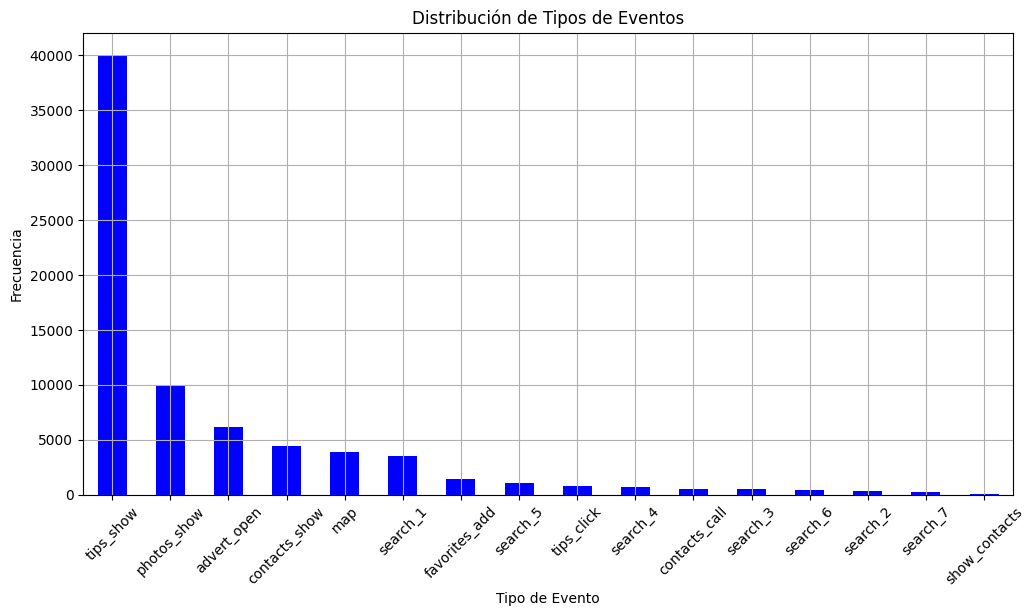

In [8]:
# Conteo de frecuencia de cada tipo de evento
event_counts = mobile_data['event.name'].value_counts()

# Crear un histograma para los eventos
plt.figure(figsize=(12, 6))
event_counts.plot(kind='bar', color='blue')
plt.title('Distribución de Tipos de Eventos')
plt.xlabel('Tipo de Evento')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Dominio de un Evento:** El evento tips_show domina claramente la actividad dentro de la aplicación, sugiriendo que los usuarios interactúan frecuentemente con elementos que probablemente ofrezcan consejos o recomendaciones.

**Menor Frecuencia en Otros Eventos:**
Eventos como advert_open (apertura de anuncios) y contacts_show (mostrar contactos) tienen una presencia notable pero significativamente menor en comparación con tips_show.

Los eventos relacionados con búsquedas (search_1 hasta search_7) y otras interacciones específicas como favorites_add (agregar a favoritos) y photos_show (mostrar fotos) tienen frecuencias mucho más bajas.


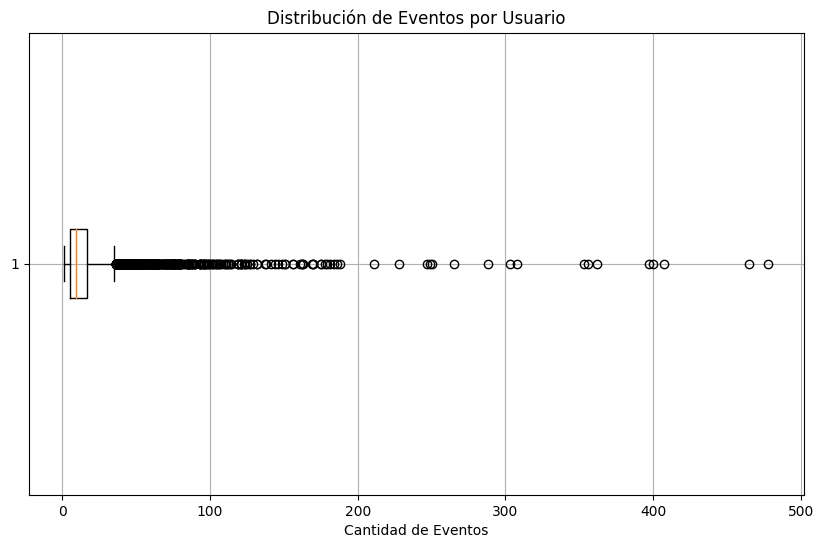

In [9]:
# Conteo de eventos por usuario
user_event_counts = mobile_data['user.id'].value_counts()

#diagrama de caja para la actividad de los usuarios
plt.figure(figsize=(10, 6))
plt.boxplot(user_event_counts, vert=False)
plt.title('Distribución de Eventos por Usuario')
plt.xlabel('Cantidad de Eventos')
plt.grid(True)
plt.show()

**Distribución General:**
La mayoría de los usuarios participan en una cantidad relativamente baja de eventos, como indica la caja compacta cerca del origen del eje X. Esto sugiere que la actividad típica por usuario no es muy alta.

**Medidas de Tendencia Central y Dispersión:**
La línea dentro de la caja, que representa la mediana, está bastante cerca del extremo inferior, indicando que más de la mitad de los usuarios tienen un número bajo de interacciones.

La caja (que representa el rango intercuartílico o IQR) es estrecha, lo que implica que la mayoría de los usuarios se concentran en un rango limitado de actividad.


**Análisis de Correlaciones:**

In [10]:
# Convertir 'event.name' y 'user.id' a formato numérico usando la codificación de frecuencia
event_frequency = mobile_data['event.name'].value_counts().to_dict()
user_frequency = mobile_data['user.id'].value_counts().to_dict()

mobile_data['event_name_freq'] = mobile_data['event.name'].map(event_frequency)
mobile_data['user_id_freq'] = mobile_data['user.id'].map(user_frequency)


In [11]:
# Renombrar la columna para el merge
mobile_sources.rename(columns={'userId': 'user.id'}, inplace=True)

combined_data = pd.merge(mobile_data, mobile_sources, on='user.id', how='left')

In [12]:
# Codificación de frecuencia para 'source'
source_frequency = combined_data['source'].value_counts().to_dict()
combined_data['source_freq'] = combined_data['source'].map(source_frequency)

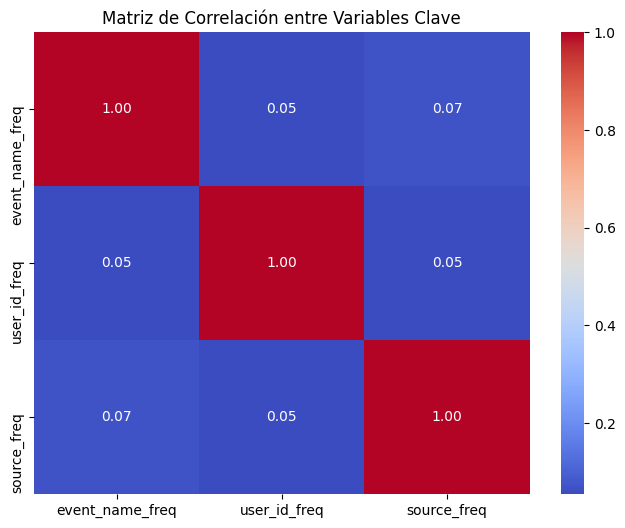

In [13]:
# Calcular la matriz de correlación
correlation_matrix = combined_data[['event_name_freq', 'user_id_freq', 'source_freq']].corr()
# Visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre Variables Clave')
plt.show()

### Segmentación de Usuarios

In [14]:
# Agrupar por 'user.id' y contar la frecuencia de cada 'event.name'
user_events = mobile_data.groupby(['user.id', 'event.name']).size().unstack(fill_value=0)

# Normalizar los datos para que las diferencias en la cantidad de eventos no distorsionen el análisis
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
user_events_scaled = scaler.fit_transform(user_events)

In [15]:
# Aplicar K-means
kmeans = KMeans(n_clusters=5, random_state=42)  # Puedes ajustar el número de clusters
clusters = kmeans.fit_predict(user_events_scaled)

# Añadir la asignación de clusters de vuelta al DataFrame original
user_events['Cluster'] = clusters

**Visualización de Segmentos**

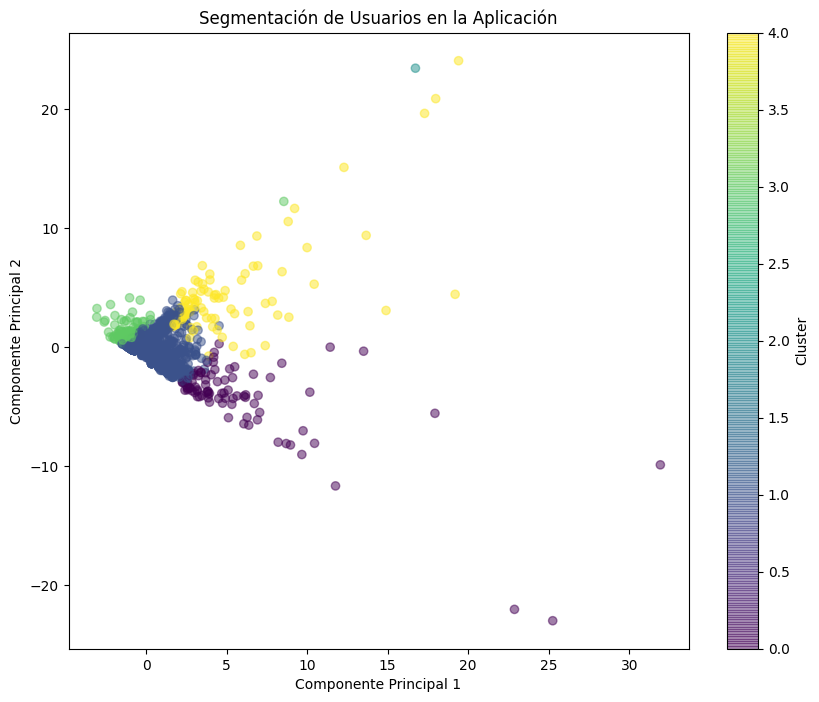

In [16]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(user_events_scaled)

# Visualización
plt.figure(figsize=(10, 8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Segmentación de Usuarios en la Aplicación')
plt.colorbar(label='Cluster')
plt.show()

**Interpretación de los Clusters:**

Los usuarios en diferentes clusters están dispersos principalmente a lo largo del Componente Principal 1, lo que sugiere que esta dimensión captura la variabilidad más significativa entre los usuarios.

Los clusters muestran variación tanto en densidad como en distribución en el espacio de componentes principales, lo cual puede indicar diferencias fundamentales en los patrones de comportamiento.

**Características de los Segmentos:**

In [17]:
# Calculando métricas clave por cluster
metrics = user_events.groupby('Cluster').agg({
    'contacts_show': ['count', 'mean'],  # Contar eventos y calcular la media para 'contacts_show'
    'favorites_add': ['mean'],  # Promedio de adiciones a favoritos
    'tips_show': ['mean'],  # Promedio de visualizaciones de consejos
    'search_1': ['mean'],  # Promedio de uso de 'search_1', puedes agregar métricas similares para otras búsquedas
}).rename(columns={
    'count': 'Frecuencia de Uso',
    'mean': 'Promedio'
})

print(metrics)

            contacts_show            favorites_add   tips_show  search_1
        Frecuencia de Uso   Promedio      Promedio    Promedio  Promedio
Cluster                                                                 
0                      87   1.850575      0.494253   20.816092  0.000000
1                    4004   0.633616      0.238012    7.431069  0.643357
2                       1  84.000000      1.000000  195.000000  0.000000
3                     101   5.346535      1.940594    1.455446  9.207921
4                     100  11.280000      2.240000   81.480000  0.000000


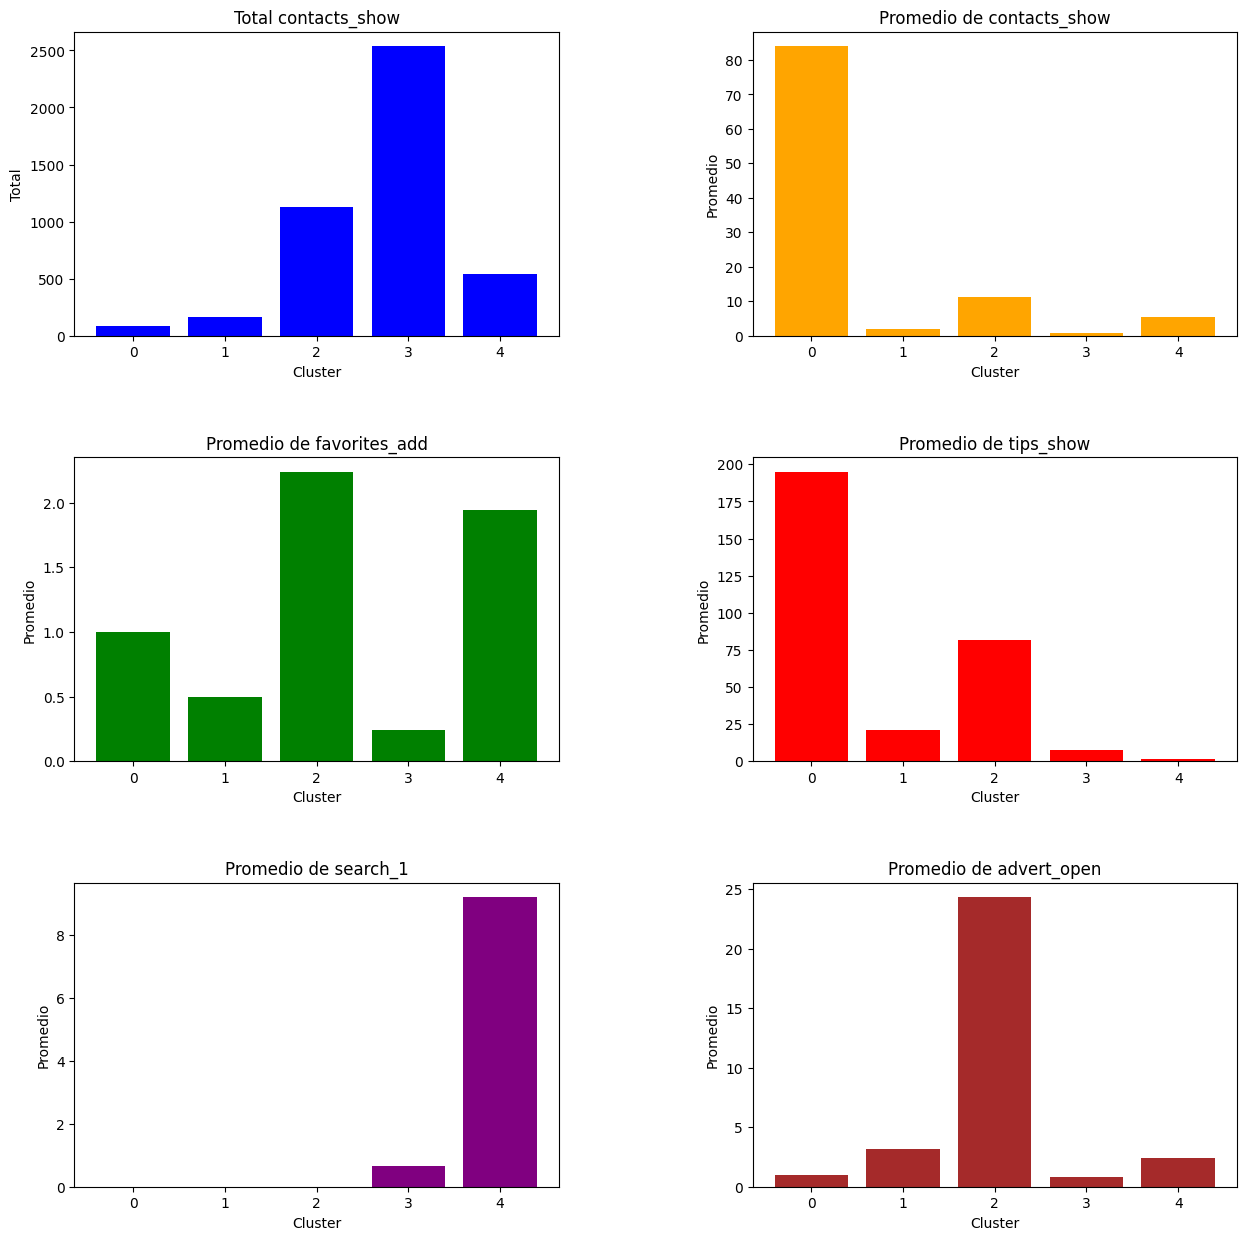

In [18]:
# Crear una figura más grande para acomodar mejor los subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # 3 filas, 2 columnas
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Ajustar el espacio horizontal y vertical

# Definir colores
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Gráfico para 'contacts_show' Total
axs[0, 0].bar(user_events['Cluster'].unique(), user_events.groupby('Cluster')['contacts_show'].sum(), color=colors[0])
axs[0, 0].set_title('Total contacts_show')
axs[0, 0].set_xlabel('Cluster')
axs[0, 0].set_ylabel('Total')

# Gráfico para 'contacts_show' Promedio
axs[0, 1].bar(user_events['Cluster'].unique(), user_events.groupby('Cluster')['contacts_show'].mean(), color=colors[1])
axs[0, 1].set_title('Promedio de contacts_show')
axs[0, 1].set_xlabel('Cluster')
axs[0, 1].set_ylabel('Promedio')

# Gráfico para 'favorites_add'
axs[1, 0].bar(user_events['Cluster'].unique(), user_events.groupby('Cluster')['favorites_add'].mean(), color=colors[2])
axs[1, 0].set_title('Promedio de favorites_add')
axs[1, 0].set_xlabel('Cluster')
axs[1, 0].set_ylabel('Promedio')

# Gráfico para 'tips_show'
axs[1, 1].bar(user_events['Cluster'].unique(), user_events.groupby('Cluster')['tips_show'].mean(), color=colors[3])
axs[1, 1].set_title('Promedio de tips_show')
axs[1, 1].set_xlabel('Cluster')
axs[1, 1].set_ylabel('Promedio')

# Gráfico para 'search_1'
axs[2, 0].bar(user_events['Cluster'].unique(), user_events.groupby('Cluster')['search_1'].mean(), color=colors[4])
axs[2, 0].set_title('Promedio de search_1')
axs[2, 0].set_xlabel('Cluster')
axs[2, 0].set_ylabel('Promedio')

# Gráfico para 'advert_open'
axs[2, 1].bar(user_events['Cluster'].unique(), user_events.groupby('Cluster')['advert_open'].mean(), color=colors[5])
axs[2, 1].set_title('Promedio de advert_open')
axs[2, 1].set_xlabel('Cluster')
axs[2, 1].set_ylabel('Promedio')

# Mostrar la figura
plt.show()

**Análisis y Estrategias Potenciales**

**Personalización de Contenido:**

Los datos sugieren que la personalización del contenido y las notificaciones basadas en los intereses específicos de cada cluster pueden mejorar la interacción del usuario. Por ejemplo, promover más activamente los contactos en el Cluster 1 y consejos en el Cluster 2.

**Optimización de la Experiencia del Usuario:**

Mejorar las características de búsqueda para el Cluster 3 y ofrecer recomendaciones personalizadas para añadir favoritos en los Clusters 3 y 4 podría aumentar la retención y satisfacción del usuario.

**Marketing y Publicidad:**

Dado que el Cluster 1 muestra una alta interacción con los anuncios, las campañas dirigidas podrían ser particularmente efectivas para este grupo.

### Prueba de Hipótesis

#### Hipótesis 1:

Diferencia en la conversión en vistas de información de contacto entre quienes descargaron la aplicación de bing y quienes la descargaron de google.
Formular la hipótesis nula y alternativa.

Utilizar pruebas estadísticas (prueba t, etc.) para probar la hipótesis.

In [19]:
# Combinar 'user_events' que ahora incluye 'contacts_show' con 'mobile_sources'
combined_data = pd.merge(user_events, mobile_sources, on='user.id', how='left')

# Segmentación por fuente
bing_contacts = combined_data[combined_data['source'] == 'bing']['contacts_show']
google_contacts = combined_data[combined_data['source'] == 'google']['contacts_show']

# Asegurarse de que hay suficientes datos para realizar las pruebas
if not bing_contacts.empty and not google_contacts.empty:
    # Prueba T para muestras independientes
    t_stat, p_val = ttest_ind(bing_contacts, google_contacts, equal_var=False)
    print("Prueba T: T-statistic =", t_stat, ", P-value =", p_val)

Prueba T: T-statistic = -0.9460292202070875 , P-value = 0.3442551322365214


##### Hipótesis 2: 

Formular y probar una hipótesis adicional basada en los datos del dataset.
Identificar una métrica o evento relevante.

Formular la hipótesis nula y alternativa.

Utilizar pruebas estadísticas apropiadas.

In [20]:
favorites_bing = combined_data[combined_data['source'] == 'bing']['favorites_add']
favorites_google = combined_data[combined_data['source'] == 'google']['favorites_add']

In [21]:
# Prueba T para muestras independientes
if not favorites_bing.empty and not favorites_google.empty:
    t_stat, p_val = ttest_ind(favorites_bing, favorites_google, equal_var=False)
    print("Prueba T: T-statistic =", t_stat, ", P-value =", p_val)

Prueba T: T-statistic = 0.20852193984508371 , P-value = 0.8348354636665394



### Conclusión General

El proyecto de segmentación de usuarios ha revelado insights valiosos sobre cómo diferentes grupos de usuarios interactúan con la aplicación. A través de una combinación de análisis estadísticos y técnicas de aprendizaje automático como K-means y PCA, hemos identificado segmentos de usuarios distintos que exhiben patrones de comportamiento únicos en cuanto a la interacción con eventos específicos de la aplicación.

Los análisis de frecuencia y promedio de eventos como 'contacts_show', 'favorites_add', 'tips_show', entre otros, han permitido identificar segmentos que varían desde usuarios altamente activos y comprometidos hasta aquellos que utilizan la aplicación de manera más pasiva o específica.

**Insights Clave**

**Interacciones Diversas:** Los usuarios no interactúan homogéneamente con la aplicación. Algunos segmentos están más enfocados en buscar información y contactos, mientras que otros prefieren interactuar con contenido o añadir favoritos.

**Comportamientos de Uso:** Determinados clusters muestran una alta actividad en áreas que podrían ser críticas para el modelo de negocio, como la visualización de anuncios y la interacción con consejos o contenidos destacados.

**Diferencias en Engagement:** Clusters específicos como el Cluster 2 y Cluster 3 muestran niveles altos de engagement en funciones que podrían ser explotadas para aumentar la retención y la monetización.

### Conclusión Final

El proyecto no solo ha mejorado la comprensión de cómo diferentes usuarios interactúan con la aplicación, sino que también ha establecido una base sólida para mejorar la interacción del usuario, la retención y la conversión. Aprovechar estos insights para personalizar y optimizar la experiencia del usuario será crucial para el éxito continuo y la evolución de la aplicación.